# Tests related to toy problem

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

import graph_utils as graph_utils
import graph_neural_networks as graph_nn
import data_preparation_utils as data_prep
from iterative_updaters import VanillaGradientDescent, MomentumGradientDescent, NesterovMomentumGradientDescent, RMSPropGradientDescent, AdamGradientDescent
import training_and_evaluation as train_eval
import graph_nn_experiments as experiments

C:\Users\Lukasz\AppData\Local\conda\conda\envs\aind\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Core methods for generating training data for the toy example:

In [2]:
def generate_dataset_based_on_graph(graph, nb_of_points):
    points = generate_points(size=graph.shape[0], nb_of_points=nb_of_points)
    values = get_values_for_points(points, graph)
    return points, values


def generate_points(size, nb_of_points):
    return np.random.randint(
        low=0, 
        high=120, 
        size=(nb_of_points, size),
    )


def get_values_for_points(points, graph):
    return np.array([get_value_for_point(point, graph) for point in points])


def get_value_for_point(point, graph):
    full_entropy = 0
    rescaled_point = point / 40.0
    for i in range(graph.shape[0]):
        row_sum = 0
        row_ent = 0
        for j in range(graph.shape[1]):
            if graph[i, j] == 0:
                continue
            current_distance = 0.5 * (point[i] - point[j]) ** 2
            exp_current_distance = np.exp(-current_distance)
            row_ent += current_distance * exp_current_distance
            row_sum += exp_current_distance
        if row_sum > 0:
            full_entropy += row_ent / row_sum + np.log(row_sum)
    return full_entropy

Load adjacency matrix for crossings in Ochota:

In [3]:
ochota_adj_matrix = np.genfromtxt("macierz_sasiedztwa.txt")

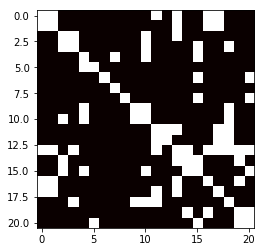

In [5]:
plt.imshow(ochota_adj_matrix, cmap='hot', interpolation='nearest')
plt.show()

Generate and save training set for the toy problem:

In [5]:
X, y = generate_dataset_based_on_graph(nb_of_points=100000, graph=ochota_adj_matrix)
Xy = np.hstack([X,y.reshape(-1,1)])
np.savetxt("toy_set.csv", Xy, delimiter=",")

**Now try the alternating transfer matrix architecture on toy dataset:**

Load the data:

In [6]:
toy_data = pd.read_csv("toy_set.csv", header=None)
toy_data.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,3.0,36.0,116.0,63.0,60.0,70.0,91.0,9.0,60.0,109.0,...,29.0,20.0,107.0,54.0,106.0,95.0,98.0,91.0,88.0,0.912229
1,97.0,114.0,59.0,103.0,67.0,45.0,99.0,70.0,37.0,53.0,...,13.0,40.0,7.0,55.0,22.0,102.0,48.0,91.0,65.0,0.063708
2,23.0,2.0,83.0,63.0,21.0,66.0,29.0,4.0,48.0,58.0,...,70.0,63.0,66.0,1.0,103.0,72.0,96.0,82.0,65.0,3.863808
3,93.0,104.0,51.0,42.0,35.0,55.0,33.0,67.0,92.0,9.0,...,9.0,77.0,55.0,74.0,76.0,14.0,16.0,36.0,82.0,1.449872
4,81.0,16.0,24.0,50.0,87.0,2.0,96.0,52.0,76.0,12.0,...,98.0,90.0,67.0,119.0,99.0,117.0,10.0,115.0,118.0,2.153349


Normalize:

In [7]:
X, y, X_scaler, y_scaler = data_prep.scale_standard_traffic_light_data(toy_data)

In [48]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-0.950000,-0.400000,0.933333,0.050000,0.000000,0.166667,0.516667,-0.850000,0.000000,0.816667,...,0.100000,-0.516667,-0.666667,0.783333,-0.100000,0.766667,0.583333,0.633333,0.516667,0.466667
1,0.616667,0.900000,-0.016667,0.716667,0.116667,-0.250000,0.650000,0.166667,-0.383333,-0.116667,...,-0.950000,-0.783333,-0.333333,-0.883333,-0.083333,-0.633333,0.700000,-0.200000,0.516667,0.083333
2,-0.616667,-0.966667,0.383333,0.050000,-0.650000,0.100000,-0.516667,-0.933333,-0.200000,-0.033333,...,0.016667,0.166667,0.050000,0.100000,-0.983333,0.716667,0.200000,0.600000,0.366667,0.083333
3,0.550000,0.733333,-0.150000,-0.300000,-0.416667,-0.083333,-0.450000,0.116667,0.533333,-0.850000,...,-0.683333,-0.850000,0.283333,-0.083333,0.233333,0.266667,-0.766667,-0.733333,-0.400000,0.366667
4,0.350000,-0.733333,-0.600000,-0.166667,0.450000,-0.966667,0.600000,-0.133333,0.266667,-0.800000,...,-0.483333,0.633333,0.500000,0.116667,0.983333,0.650000,0.950000,-0.833333,0.916667,0.966667


In [49]:
X_scaler.inverse_transform(X).head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,3.0,36.0,116.0,63.0,60.0,70.0,91.0,9.0,60.0,109.0,...,66.0,29.0,20.0,107.0,54.0,106.0,95.0,98.0,91.0,88.0
1,97.0,114.0,59.0,103.0,67.0,45.0,99.0,70.0,37.0,53.0,...,3.0,13.0,40.0,7.0,55.0,22.0,102.0,48.0,91.0,65.0
2,23.0,2.0,83.0,63.0,21.0,66.0,29.0,4.0,48.0,58.0,...,61.0,70.0,63.0,66.0,1.0,103.0,72.0,96.0,82.0,65.0
3,93.0,104.0,51.0,42.0,35.0,55.0,33.0,67.0,92.0,9.0,...,19.0,9.0,77.0,55.0,74.0,76.0,14.0,16.0,36.0,82.0
4,81.0,16.0,24.0,50.0,87.0,2.0,96.0,52.0,76.0,12.0,...,31.0,98.0,90.0,67.0,119.0,99.0,117.0,10.0,115.0,118.0


In [50]:
y_scaler.inverse_transform(y)

array([0.91222938, 0.06370843, 3.863808  , ..., 2.12677172, 3.50303496,
       3.8080778 ])

Some data insights:

1.3469049658032791e-40


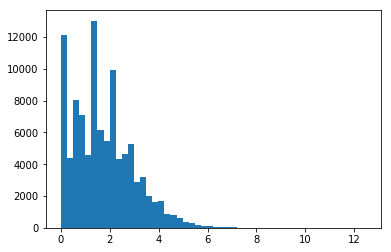

In [97]:
p_ = plt.hist(toy_data.iloc[:,21], bins=50)
print(min(toy_data.iloc[:,21]))

Normalization seems to work ok.

Train test split:

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=831191)

Now construct the neural net and define the loss:

In [81]:
nn_input = tf.placeholder(dtype=tf.float32, shape=[None, 21])
targets = tf.placeholder(dtype=tf.float32, shape=[None, 1])
# this one works fine for toy problem: ..._net(nn_input, 3, 2, tf.nn.tanh, ochota_adj_matrix..., 3, 4 also works very well
nn_output = graph_nn.transfer_matrix_neural_net(nn_input, 3, 4, tf.nn.tanh, ochota_adj_matrix, verbose=True, share_weights_in_transfer_matrix=False, share_biases_in_transfer_matrix=False)

(21, 48, 1, 4)
(?, 48, 4)
(48, 21, 4, 4)
(?, 21, 4)
(21, 48, 4, 4)
(?, 48, 4)
(?, 192)


__NOTE__: transfer_matrix_neural_net(traffic_signal_settings, 3, 4, tf.nn.tanh, ochota_adj_matrix) seems to work ok (+ Adam using 0.01 learning rate)

Now define the optimizer:

In [82]:
optimizer = tf.train.AdamOptimizer(0.005) #0.0035

Define batch iterator: 

In [83]:
batch_iterator = data_prep.BatchIterator(X_train, y_train, 997)

Now, train for several epochs:

In [84]:
test_and_batch_losses = train_eval.train_model(nn_output, nn_input, targets, optimizer, 100000, batch_iterator, X_test, y_test, "trained_networks/test_model.ckpt", 1000, verbose=True)

Test loss: 1.067633, batch loss: 1.039141, model saved under trained_networks/test_model.ckpt
Test loss: 0.964787, batch loss: 0.879653, model saved under trained_networks/test_model.ckpt
Test loss: 0.956827, batch loss: 0.928736, model saved under trained_networks/test_model.ckpt
Test loss: 0.912852, batch loss: 0.958222, model saved under trained_networks/test_model.ckpt
Test loss: 0.859871, batch loss: 0.845640, model saved under trained_networks/test_model.ckpt
Test loss: 0.789902, batch loss: 0.819555, model saved under trained_networks/test_model.ckpt
Test loss: 0.726970, batch loss: 0.737484, model saved under trained_networks/test_model.ckpt
Test loss: 0.682902, batch loss: 0.722054, model saved under trained_networks/test_model.ckpt
Test loss: 0.641682, batch loss: 0.601089, model saved under trained_networks/test_model.ckpt
Test loss: 0.611788, batch loss: 0.608177, model saved under trained_networks/test_model.ckpt
Test loss: 0.591937, batch loss: 0.564992, model saved under

Test loss: 0.054166, batch loss: 0.049557, model saved under trained_networks/test_model.ckpt
Test loss: 0.053101, batch loss: 0.046637, model saved under trained_networks/test_model.ckpt
Test loss: 0.054325, batch loss: 0.048401, model saved under trained_networks/test_model.ckpt
Test loss: 0.052912, batch loss: 0.046581, model saved under trained_networks/test_model.ckpt
Test loss: 0.052074, batch loss: 0.052029, model saved under trained_networks/test_model.ckpt
Test loss: 0.050244, batch loss: 0.053352, model saved under trained_networks/test_model.ckpt
Test loss: 0.048675, batch loss: 0.045648, model saved under trained_networks/test_model.ckpt
Test loss: 0.048689, batch loss: 0.047270, model saved under trained_networks/test_model.ckpt
Test loss: 0.049935, batch loss: 0.047261, model saved under trained_networks/test_model.ckpt
Test loss: 0.048019, batch loss: 0.049212, model saved under trained_networks/test_model.ckpt
Test loss: 0.049722, batch loss: 0.042558, model saved under

Check relative accuracy on test set:

In [93]:
model_avg_error, actual_vs_predicted = train_eval.evaluate_toy_model_on_a_dataset("trained_networks/test_model.ckpt", nn_output,nn_input, X_test, y_test, y_scaler)
print(model_avg_error)

INFO:tensorflow:Restoring parameters from trained_networks/test_model.ckpt
0.04767262460957649


Text(0.5,1,'Actual vs. predicted')

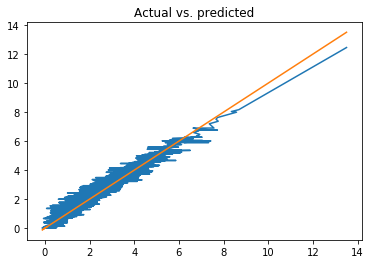

In [94]:
y_test_sorted = [x[0] for x in actual_vs_predicted]
y_test_pred_sorted = [x[1] for x in actual_vs_predicted]
plt.plot(y_test_pred_sorted, y_test_sorted)
plt.plot(y_test_pred_sorted, y_test_pred_sorted)
plt.title("Actual vs. predicted")

Now feedforward:

In [10]:
nn_input = tf.placeholder(dtype=tf.float32, shape=[None, 21])
targets = tf.placeholder(dtype=tf.float32, shape=[None, 1])

# simple feedforward neural net works much worse
nn_output = tf.layers.dense(nn_input, 40, activation=tf.nn.tanh)
nn_output = tf.layers.dense(nn_output, 40, activation=tf.nn.tanh)
nn_output = tf.layers.dense(nn_output, 40, activation=tf.nn.tanh)
nn_output = tf.layers.dense(nn_output, 1)

In [11]:
optimizer = tf.train.AdamOptimizer(0.005)

In [12]:
batch_iterator = data_prep.BatchIterator(X_train, y_train, 997)

In [13]:
test_and_batch_losses = train_eval.train_model(nn_output, nn_input, targets, optimizer, 100000, batch_iterator, X_test, y_test, "trained_networks/feedforward_test_toy_model.ckpt", 1000, verbose=True)

Test loss: 1.064946, batch loss: 1.182546, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.970659, batch loss: 0.890029, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.982254, batch loss: 0.916147, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.988402, batch loss: 0.997349, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.004339, batch loss: 0.910136, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.022107, batch loss: 0.915059, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.034172, batch loss: 0.830933, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.043808, batch loss: 0.893621, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.054036, batch loss: 0.902936, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss:

Test loss: 1.133623, batch loss: 0.827674, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.134132, batch loss: 0.857179, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.139858, batch loss: 0.754172, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.137401, batch loss: 0.783244, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.133516, batch loss: 0.795784, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.129046, batch loss: 0.844079, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.137943, batch loss: 0.788234, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.132463, batch loss: 0.799652, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.134150, batch loss: 0.788027, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss:

Another architecture (10 neurons):

In [14]:
nn_input = tf.placeholder(dtype=tf.float32, shape=[None, 21])
targets = tf.placeholder(dtype=tf.float32, shape=[None, 1])

# simple feedforward neural net works much worse
nn_output = tf.layers.dense(nn_input, 10, activation=tf.nn.tanh)
nn_output = tf.layers.dense(nn_output, 10, activation=tf.nn.tanh)
nn_output = tf.layers.dense(nn_output, 10, activation=tf.nn.tanh)
nn_output = tf.layers.dense(nn_output, 1)

In [15]:
optimizer = tf.train.AdamOptimizer(0.005)

In [16]:
batch_iterator = data_prep.BatchIterator(X_train, y_train, 997)

In [17]:
test_and_batch_losses = train_eval.train_model(nn_output, nn_input, targets, optimizer, 100000, batch_iterator, X_test, y_test, "trained_networks/feedforward_test_toy_model.ckpt", 1000, verbose=True)

Test loss: 1.032427, batch loss: 1.017765, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.972883, batch loss: 0.889755, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.972625, batch loss: 0.957167, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.970722, batch loss: 1.039392, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.971189, batch loss: 0.954167, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.972496, batch loss: 1.009697, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.975026, batch loss: 0.935508, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.974830, batch loss: 0.985035, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.974907, batch loss: 1.003249, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss:

Test loss: 0.984786, batch loss: 0.949419, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.986537, batch loss: 0.986170, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.987977, batch loss: 0.976302, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.987983, batch loss: 0.917297, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.987729, batch loss: 0.968038, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.988776, batch loss: 1.004130, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.990980, batch loss: 0.879340, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.988016, batch loss: 0.996038, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.987533, batch loss: 0.865854, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss:

Yet another architecture (100 neurons):

In [18]:
nn_input = tf.placeholder(dtype=tf.float32, shape=[None, 21])
targets = tf.placeholder(dtype=tf.float32, shape=[None, 1])

# simple feedforward neural net works much worse
nn_output = tf.layers.dense(nn_input, 100, activation=tf.nn.tanh)
nn_output = tf.layers.dense(nn_output, 100, activation=tf.nn.tanh)
nn_output = tf.layers.dense(nn_output, 100, activation=tf.nn.tanh)
nn_output = tf.layers.dense(nn_output, 1)

In [19]:
optimizer = tf.train.AdamOptimizer(0.005)

In [20]:
batch_iterator = data_prep.BatchIterator(X_train, y_train, 997)

In [21]:
test_and_batch_losses = train_eval.train_model(nn_output, nn_input, targets, optimizer, 100000, batch_iterator, X_test, y_test, "trained_networks/feedforward_test_toy_model.ckpt", 1000, verbose=True)

Test loss: 1.207266, batch loss: 1.091750, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 0.971868, batch loss: 0.876591, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.001098, batch loss: 0.871238, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.067722, batch loss: 0.877276, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.170542, batch loss: 0.765188, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.218843, batch loss: 0.715081, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.252600, batch loss: 0.660021, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.289201, batch loss: 0.644560, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.309556, batch loss: 0.639668, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss:

Test loss: 1.587703, batch loss: 0.437889, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.596391, batch loss: 0.408608, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.567925, batch loss: 0.303264, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.579770, batch loss: 0.418447, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.565085, batch loss: 0.402173, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.577599, batch loss: 0.409263, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.579799, batch loss: 0.399627, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.586121, batch loss: 0.415109, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss: 1.586944, batch loss: 0.389376, model saved under trained_networks/feedforward_test_toy_model.ckpt
Test loss:

### Random graph topology experiments

In [22]:
random_topologies_results = np.genfromtxt("toy_random_topologies_0.csv",delimiter=",")

In [24]:
rand_top_data_frame = pd.DataFrame(random_topologies_results, columns=["SymmetricDiff","MeanSquaredError"])
medians = rand_top_data_frame.groupby("SymmetricDiff").median()
medians

,MeanSquaredError
SymmetricDiff,
0.0,0.070856
3.0,0.110634
6.0,0.150053
9.0,0.187124
12.0,0.212823
15.0,0.236301
18.0,0.287529
21.0,0.292137
24.0,0.323680


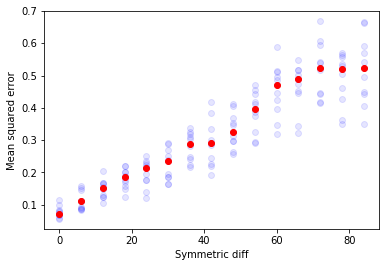

In [26]:
plt.plot(rand_top_data_frame.iloc[:,0] * 2,rand_top_data_frame.iloc[:,1],"bo", alpha=0.1)
plt.plot(medians.index.values * 2,medians.iloc[:,0], "ro")
plt.xlabel("Symmetric diff")
plt.ylabel("Mean squared error")
plt.show()

### Permuted topologies experiments summary

In [30]:
permuted_topologies_results = np.genfromtxt("toy_permuted_topologies_0.csv",delimiter=",")

In [31]:
perm_top_data_frame = pd.DataFrame(permuted_topologies_results, columns=["NoOfTranspositions","MeanSquaredError"])
medians = perm_top_data_frame.groupby("NoOfTranspositions").median()
medians

,MeanSquaredError
NoOfTranspositions,
0.0,0.075488
1.0,0.154979
2.0,0.193782
3.0,0.320528
4.0,0.372339
5.0,0.387373
6.0,0.369838
7.0,0.497559
8.0,0.485433


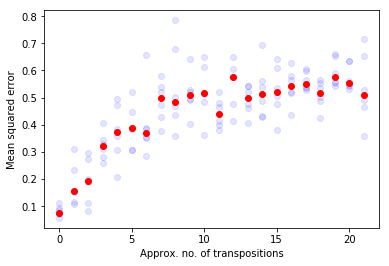

In [35]:
plt.plot(perm_top_data_frame.iloc[:,0],perm_top_data_frame.iloc[:,1],"bo",alpha=0.1)
plt.plot(medians.index.values,medians.iloc[:,0], "ro")
plt.xlabel("Approx. no. of transpositions") # <-- not divided by two here
plt.ylabel("Mean squared error")
plt.show()